In [1]:
!pip install transformers
!pip install datasets

DEPRECATION: Loading egg at c:\users\wiebke petersen\anaconda3\lib\site-packages\huggingface_hub-0.16.4-py3.8.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


DEPRECATION: Loading egg at c:\users\wiebke petersen\anaconda3\lib\site-packages\huggingface_hub-0.16.4-py3.8.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [2]:
import sys
import urllib
import datasets
import matplotlib.pyplot as plt
import torch
import transformers
import numpy as np
import pandas as pd


# Text Classification with Transformers

For training transformers you need access to an NVIDIA GPU. Personally, I use [Google Colab](https://colab.research.google.com/). Alternatives are [Kaggle Notebooks](https://www.kaggle.com/docs/notebooks) and [Paperspace Gradient](https://learn.paperspace.com/product/gradient)

## Data Loading and Preprocessing

This notebook is following Chapter 2 of _Natural Language Processing with Transformers_ by Lewis Tunstall, Leandro von Werra and Thomas Wolf (revised edition,  O'Reilly 2022)

### Simple case: dataset avaiable at HuggingFace

In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

How does the dataset look like?

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds[17]

{'text': 'i feel pretty pathetic most of the time', 'label': 0}

In [7]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [8]:
train_ds.features["label"].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [9]:
for i in range(8):
    data=train_ds[i]
    print(data['label'], 
          train_ds.features["label"].names[data['label']] , 
          "\t", data['text'])
    

0 sadness 	 i didnt feel humiliated
0 sadness 	 i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
3 anger 	 im grabbing a minute to post i feel greedy wrong
2 love 	 i am ever feeling nostalgic about the fireplace i will know that it is still on the property
3 anger 	 i am feeling grouchy
0 sadness 	 ive been feeling a little burdened lately wasnt sure why that was
5 surprise 	 ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny
4 fear 	 i feel as confused about life as a teenager or as jaded as a year old man


### Load Dataset if not avaiable at HuggingFace

View the data:

In [12]:
from urllib.request import urlopen

url_path = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"

data = urlopen(url_path)

for i in range(3):
        line = next(data).strip()
        print(line)

b'i didnt feel humiliated;sadness'
b'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness'
b'im grabbing a minute to post i feel greedy wrong;anger'


In [25]:
ds = load_dataset("csv", 
                  data_files=url_path,  # data_files is either an url or a path to a local file 
                  sep=";", names=["text", "label"])

In [26]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
})

Load and split in test and train:

In [27]:
ds["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None)}

The features must be adapted and numerical class labels must be added:

In [28]:
print(ds["train"]["label"][:5])
ds = ds.class_encode_column("label")
print(ds["train"]["label"][:5])

['sadness', 'sadness', 'anger', 'love', 'anger']
[4, 4, 0, 3, 0]


In [29]:
print(ds["train"].features)
print(ds["train"][0])

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], id=None)}
{'text': 'i didnt feel humiliated', 'label': 4}


In [30]:
emotions = ds["train"].train_test_split(shuffle=True,test_size=0.1)
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 14400
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
})

### Study data

With`set_format` the output style of a data set can be changed without changing the data set itself: 

In [31]:
emotions.set_format(type="pandas")  # set_format only changes output style
df = emotions["train"][:]
df.head()

,text,label
0,i do feel envious of those with kids at certai...,0
1,i feel like this another one of the more under...,2
2,i was feeling pretty rotten,4
3,i feel like the thing im most nervous about is...,1
4,i tired of hearing of these unique communicati...,2


In [33]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i do feel envious of those with kids at certai...,0,anger
1,i feel like this another one of the more under...,2,joy
2,i was feeling pretty rotten,4,sadness
3,i feel like the thing im most nervous about is...,1,fear
4,i tired of hearing of these unique communicati...,2,joy


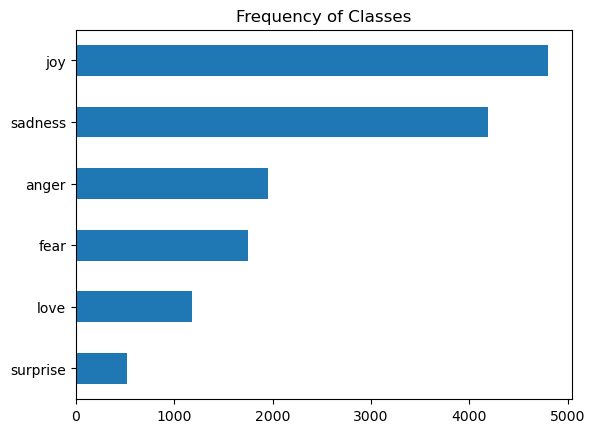

In [34]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

**Note:** imbalanced data! For training, better either oversample small classes or undersample big classes or get more data.

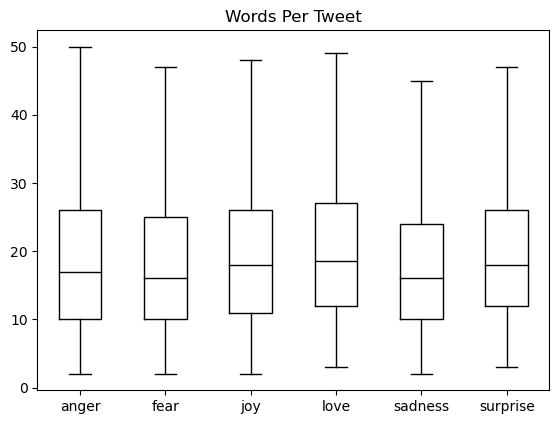

In [35]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

**Note:** no tweet is longer than 50 words => shorter than context sizes of standard language models => no truncation needed => no information loss 

In [36]:
emotions.reset_format() # reset output format

## Tokenization

### Introduction to Autotokenizer 

If you want to work with a pretrained model (e.g. DistilBERT), make sure to use the same tokenizer for your data that was used for training the model.

In [37]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

c:\Users\Wiebke Petersen\anaconda3\Lib\site-packages\huggingface_hub-0.16.4-py3.8.egg\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Wiebke Petersen\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


DistilBERT is a relatively small model that was trained to mimick the much bigger model BERT. [Distilbert on HuggingFace](https://huggingface.co/distilbert-base-uncased)

In [41]:
text = "DistilBERT is a relatively small model that was trained to mimick ..."
#text = "Morphology is dealing with prefixed words like 'autosuggested'"

tokenized = tokenizer(text)
print(tokenized)

{'input_ids': [101, 4487, 16643, 23373, 2003, 1037, 4659, 2235, 2944, 2008, 2001, 4738, 2000, 23150, 2243, 1012, 1012, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [42]:
tokens = tokenizer.convert_ids_to_tokens(tokenized.input_ids)
print(tokens)

['[CLS]', 'di', '##sti', '##lbert', 'is', 'a', 'relatively', 'small', 'model', 'that', 'was', 'trained', 'to', 'mimic', '##k', '.', '.', '.', '[SEP]']


Search the file "vocab.txt" on your machine and look at it. It is the vocabulary used by the Tokenizer of DistilBERT

In [43]:
tokenizer.vocab_size

30522

maximal context size:

In [44]:
tokenizer.model_max_length

512

In [45]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Further attributes of tokenizer: [Documentation](https://huggingface.co/docs/transformers/main_classes/tokenizer)

### Tokenize whole dataset

Large datasets should be tokenized in batches. However, as our dataset is small, we tokenize it in one batch.

In [46]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [51]:
demonstrate = tokenize(emotions["train"][:3])
for i in range(3):
    print(demonstrate["input_ids"][i])  
    print(demonstrate["attention_mask"][i])
    print()


[101, 1045, 2079, 2514, 4372, 24918, 1997, 2216, 2007, 4268, 2012, 3056, 5312, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[101, 1045, 2514, 2066, 2023, 2178, 2028, 1997, 1996, 2062, 2104, 9250, 2636, 2006, 1996, 2201, 2025, 2183, 2000, 2022, 1996, 2087, 2759, 2021, 2019, 6429, 2501, 9690, 102]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

[101, 1045, 2001, 3110, 3492, 11083, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



Note that the 2nd and 3rd tweet have been padded by 0 to get inputs of same length. `attention_mask` defines the padded and non-padded sections of the inputs.

In [52]:
emotions_tokenized = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/14400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [53]:
emotions_tokenized["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

## Text Classifier Model

### Using a pipeline without model fine-tuning

For our exact task, we do not have a pipeline with a trained model avaliable. However, there is a similar task, namely sentiment analysis for which a pipeline exists.

In [54]:
from transformers import pipeline
classifier = pipeline("sentiment-analysis")
result = classifier(["I hate bad movies", "I love chocolate"])
print(result)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'NEGATIVE', 'score': 0.9951816201210022}, {'label': 'POSITIVE', 'score': 0.999846339225769}]


**Note** that `transformers` has automatically chosen a model pretrained on this specific task (Sentiment Analysis).

If it is sufficient for us to only distinguish between positive and negative feelings, we can probably use this model and the pre-build pipeline. We will just try it on the test set.

In [55]:
emotion_sentAn = classifier(emotions["test"]["text"])

In [56]:
for i in range(5):
    print(emotions["test"][i])
    print(emotion_sentAn[i])

{'text': 'i feel like strangling horny bastards schools people for banging our boats and not even syaing sorry', 'label': 3}
{'label': 'NEGATIVE', 'score': 0.9917846918106079}
{'text': 'i feel like theres a dangerous chance that im pulling a don quixote on this blinding rushing at the windmill that is my eventual marriage or future child', 'label': 0}
{'label': 'NEGATIVE', 'score': 0.9930621981620789}
{'text': 'i don t feel rejected or abandoned which speaks volumes to the expansion of my self worth', 'label': 4}
{'label': 'POSITIVE', 'score': 0.9993778467178345}
{'text': 'i didn t feel particularly mad of course they say that when you are going crazy you really feel like you are becoming more sane', 'label': 0}
{'label': 'POSITIVE', 'score': 0.5758697390556335}
{'text': 'i finally feel like im getting treatment for my injury and that im not being punished for having been injured during an assault', 'label': 4}
{'label': 'POSITIVE', 'score': 0.9894096851348877}


We will see how well we have done, by dividing our old labels into positive and negative labels.

In [57]:
old_labels_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
new_labels = ["NEGATIVE","NEGATIVE","POSITIVE","POSITIVE","NEGATIVE","POSITIVE"]


def change_labels(label_list):
    new_labels_list = []
    for label in label_list:
        new_labels_list.append(new_labels[label])
    return(new_labels_list)

new_labels_list = change_labels(emotions["test"]["label"])
    

A simple evaluation:

In [58]:
total = len(new_labels_list)
emotion_sentAn_list = [d["label"] for d in emotion_sentAn]

def compAcc(list):
    c = 0
    for i in range(total):
        if list[i] == emotion_sentAn_list[i]:
            c += 1
    print("accuracy:", c/total)

compAcc(new_labels_list)

accuracy: 0.75625


Compare to two baselines. (1) chance(50:50 or according to distribution in train set), (2) all negative/positive

In [59]:
import random
prob50 = random.choices(['NEGATIVE','POSITIVE'],
                        weights=[1,1],k=total)
s = emotion_sentAn_list.count("POSITIVE")
p = s/total
probData = random.choices(['NEGATIVE','POSITIVE'],
                          weights=[1-p,p],k=total)
allPos = ["POSITIVE" for i in range(total)]
allNeg = ["NEGATIVE" for i in range(total)]

print("Baseline - 50% chance:")
compAcc(prob50)
print("Baseline - chance relative to test data:")
compAcc(probData)
print("Baseline - all positive:")
compAcc(allPos)
print("Baseline - all negative:")
compAcc(allNeg)


Baseline - 50% chance:
accuracy: 0.505
Baseline - chance relative to test data:
accuracy: 0.50875
Baseline - all positive:
accuracy: 0.410625
Baseline - all negative:
accuracy: 0.589375


### Transformers as Features Extractors

If we do not have an adequate pipeline avaiable, we first have to choose an appropriate pretrained model for our classification task.

Such a model expects a sequence of tokens (i.e. tokenized text). The sequence of global embeddings of the tokens is send through a (stack of) decoder(s). The final hidden layer can be interpreted as a sequence of contextualized embeddings of the tokens.

To adapt the model for our specific task we can

1. either use the last hidden layer as features for a classifier (i.e. using the transformer as feature extractor) or
2. add a classifier net to the last hidden layer and train the whole model (that is called fine-tuning the model)

We will first use the transformer as a **feature extractor**.

Advantages:

* fast
* low computational resources needed (CPU is sufficient)
* any classifier can be used, not restricted to a neural net classifier

As model we use `distilbert-base-uncased` as before and load it with the method `AutoModel` that gives us the pure pretrained transformer without a task specific head.

We will use a GPU if avaiable and load the model onto it:

In [60]:
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint).to(device)

We will first see what happens if we feed a single sequence through the model:

In [61]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
print(f"{inputs['input_ids'].size()[0]} batches and {inputs['input_ids'].size()[1]} tokens")
print(f"Tokenized string: {tokenizer.convert_ids_to_tokens(inputs.input_ids[0])}")


Input tensor shape: torch.Size([1, 6])
1 batches and 6 tokens
Tokenized string: ['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']


Let's investigate `inputs`

In [62]:
print("inputs (a dictionary)")
print(inputs)
print("inputs.item() (dict_items: kind of list of pairs)")
print(inputs.items())

inputs (a dictionary)
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
inputs.item() (dict_items: kind of list of pairs)
dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])


Now we move the tokens to the device and feed them into the model:

In [63]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


`with torch.no_grad():` disables the automatic calculation of the gradient (saves memory) 

Let's investigate `outputs`

In [64]:
outputs.last_hidden_state

tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]])

In [65]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [66]:
print(f"batch size: {outputs.last_hidden_state.size()[0]}, \nnumber of tokens: {outputs.last_hidden_state.size()[1]}, \ndimension of last hidden layer: {outputs.last_hidden_state.size()[2]}")

batch size: 1, 
number of tokens: 6, 
dimension of last hidden layer: 768


Each of the six tokens is now represented as a vector of length 768.

For a classification task like ours, we are only interested in the representation of the `[CLS]`-token:

In [67]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

The next step ist to extract the hidden state of the `CLS`-token for each sequence in our training and test data:

In [68]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

Note that the `map()` method requires that the processed function returns Python objects, that is why we move the last hidden state back to CPU (`.cpu()`) and turn it into a NumPy array (`.numpy()`).

Remember that `emotions_tokenized` contains our tokenized train and test data:

In [69]:
emotions_tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 14400
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In order to feed them to our model, we bring them into the `torch` format:

In [71]:
emotions_tokenized.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

With the `map` method we can now extract the hidden states. Note, this will take quite a while (up to an hour) if you are not working on a GPU.

In [72]:
emotions_hidden = emotions_tokenized.map(extract_hidden_states, batched=True, batch_size = 500)

Map:   0%|          | 0/14400 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_test = np.array(emotions_hidden["test"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_test = np.array(emotions_hidden["test"]["label"])
X_train.shape, X_test.shape

((14400, 768), (1600, 768))

In [ ]:
X_test[:3,:10]

array([[ 0.09124307,  0.09077901, -0.03413414, -0.25176308, -0.18330225,
        -0.27073428,  0.34661856,  0.46897984, -0.22121744, -0.39950106],
       [-0.16078612,  0.07490189, -0.2262533 , -0.2996612 , -0.31607062,
        -0.09254174,  0.51398516,  0.39197326,  0.06296168, -0.56494594],
       [ 0.14079672,  0.10199372, -0.11820048, -0.23272163, -0.25907293,
        -0.16953512,  0.35544443,  0.5804243 , -0.15658565, -0.3649885 ]],
      dtype=float32)

In [ ]:
# save for later use
np.save("X_train.npy",X_train)
np.save("X_test.npy",X_test)
np.save("y_train.npy",y_train)
np.save("y_test.npy",y_test)


In [ ]:
# load
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")



#### Visualizing the hidden state features

As we cannot visualize 768 dimensions directly, we have to reduce the dimensionality of our feature space. 

Therefore we use the UMAP algorithm [Uniform Manifold Approximation and Projection](https://arxiv.org/abs/1802.03426) a dimensionality reduction algorithm that is based on neighboring graphs.

If you want to play around with UMAP to understand it, you can do it [here](https://pair-code.github.io/understanding-umap/)

And [here](https://www.youtube.com/watch?v=6BPl81wGGP8) is a helpful video on the idea behind the UMAP algorithm.

To use UMAP we must first scaled to lie in the [0,1] interval. This will be done with the `MinMaxScaler` from scikit-learn. Its formula is

$x_{\textit{scaled} = \frac{x-x_{\textit{min}}{x_{\textit{max}-x_{\textit{min}}$

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.8 MB/s 
     |████████████████████████████████| 1.1 MB 51.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=12034080ca68c6aa3b6cc2ccd2a829ba35d8951af8e450def614bf716ef4ddee
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=2697d4973e2ec55e48476465a29dfe3266770c168ccc10b4b96052e4c91eeb01
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,0.448896,3.677721,0
1,-0.310206,5.629040,4
2,-3.538839,1.732049,2
3,-1.284862,2.742145,2
4,5.277748,3.801653,2


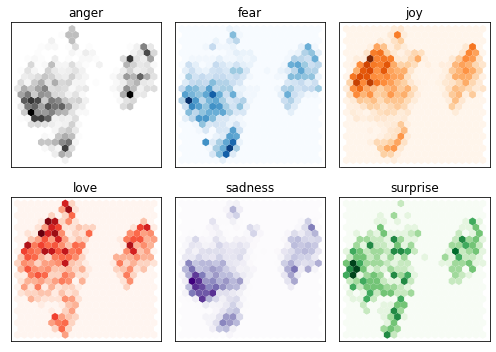

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


#### Training a classifier

We will train a simple logistic regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.62875

Let's again compare this result to a baseline classifier:

Classifier predicts always the most frequent class

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.344375

Classifier predicts all classes by equal chance

In [ ]:
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.171875

Classifier predicts each class by the empirical class prior probabilities

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.22625

Our classifier outperforms all the baselines by far.

Next we will look at the [confusion matrix](https://de.wikipedia.org/wiki/Beurteilung_eines_bin%C3%A4ren_Klassifikators#Wahrheitsmatrix:_Richtige_und_falsche_Klassifikationen):

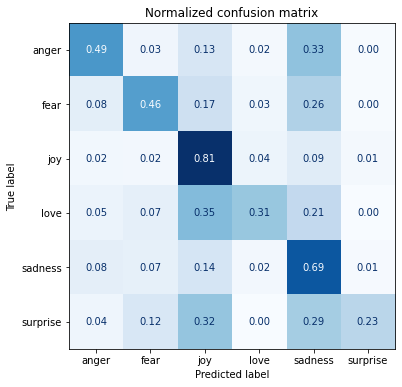

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, labels)

The confusion matrix shows which classes are often confused. E.g. `love` is often confused with `joy`. It also shows that `love` and `surprise` are both badly detected, while `joy` is rather well classified.

### Fine-Tuning a pretrained transformer model

In the 'Transformers as Features Extractors' case above, we used a separate classifier that took the last hidden layer of the transformer as input features. Thus the transformers weights have not been changed in the process. 

Now we are going to fine-tune a transformer by updating its weights. The classifier layer will now be attached to the transformer and in the training process both, the weights of the classifier layer and the weights of the original transformer layers will be updated simultaneously. 

By choosing a model from `AutoModelForSequenceClassification` we get a model that is already equipped with a neural net classifier of the desired size (`num_labels`)  

In [ ]:
from transformers import AutoModelForSequenceClassification

model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=6)
         .to(device))

HuggingFace allows users with an account to save their models on the HuggingFace hub in order to publish their models and reuse them. In order to do so, we need to log in to the Hub (if you do not want to create an account, just comment out all lines and cells marked by `# HuggingFace account necessary`):

In [ ]:
# HuggingFace account necessary
from huggingface_hub import notebook_login

notebook_login()

# if working from a terminal use $ huggingface-cli login

Login successful
Your token has been saved to /root/.huggingface/token


To train the model we use the `Trainer` API from Transformers.

In order to do so, we first have to define a **performance metrics** that evaluates the performance of our model during training. Our `compute_metrics` function expects an `EvalPrediction object` that is a pair of a prediction and a label. The function returns the [F1 (harmonic mean of precision and recall)](https://en.wikipedia.org/wiki/F-score) and the accuracy score as a dictionary. Here, the F1-score is computed by weighting the F1-scores of the individual labels by their support, i.e. the number of true instances for each label. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) for details on alternative F1-score calculation methods. 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Additionally we have to set the `TrainingArguments` for the `Trainer`:

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_tokenized["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, # HuggingFace account necessary
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_tokenized["train"],
                  eval_dataset=emotions_tokenized["test"],
                  tokenizer=tokenizer)

/content/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/Wiebke/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.


For comparision we also compute the predictions by the original not yet fine-tuned model:

In [ ]:
preds_output_original = trainer.predict(emotions_tokenized["test"])
preds_output_original.metrics

{'test_loss': 1.8396530151367188,
 'test_accuracy': 0.035,
 'test_f1': 0.002372881355932203,
 'test_runtime': 3.7354,
 'test_samples_per_second': 428.333,
 'test_steps_per_second': 6.693}

Now we can fine-tune our model:

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.938800,0.369946,0.898750,0.894098
2,0.306300,0.245761,0.924375,0.923723


TrainOutput(global_step=450, training_loss=0.6225539991590712, metrics={'train_runtime': 216.1603, 'train_samples_per_second': 133.234, 'train_steps_per_second': 2.082, 'total_flos': 648308575526400.0, 'train_loss': 0.6225539991590712, 'epoch': 2.0})

With the `.predict()` method of `Trainer`we can use our now trained model to make predictions

In [ ]:
preds_output = trainer.predict(emotions_tokenized["test"])

In [ ]:
preds_output

PredictionOutput(predictions=array([[-1.3829468 , -1.7544708 ,  3.8178937 ,  0.14857301, -1.3517097 ,
        -0.30138633],
       [-0.38377103,  3.165462  , -1.6311541 , -1.5386425 ,  0.09224883,
        -0.92016137],
       [-0.2061689 , -0.73616344, -0.70761263, -1.2517842 ,  4.185613  ,
        -1.1724647 ],
       ...,
       [ 1.8146094 ,  0.26584163, -1.6997398 , -1.5368582 ,  2.5249038 ,
        -1.3538489 ],
       [ 1.2722852 ,  2.3877678 , -1.962271  , -2.1323676 ,  0.45986912,
        -0.60133195],
       [-1.2107733 , -0.8384343 ,  3.16175   , -0.63675374, -1.0804203 ,
        -0.5389406 ]], dtype=float32), label_ids=array([2, 1, 4, ..., 0, 1, 2]), metrics={'test_loss': 0.24576111137866974, 'test_accuracy': 0.924375, 'test_f1': 0.9237228192473927, 'test_runtime': 3.6582, 'test_samples_per_second': 437.37, 'test_steps_per_second': 6.834})

In [ ]:
preds_output.metrics

{'test_loss': 0.24576111137866974,
 'test_accuracy': 0.924375,
 'test_f1': 0.9237228192473927,
 'test_runtime': 3.6582,
 'test_samples_per_second': 437.37,
 'test_steps_per_second': 6.834}

`.predict()` also returns an array of the raw predictions (`.predictions`) for the class labels. We transform them into predicted labels by `np.argmax()`

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

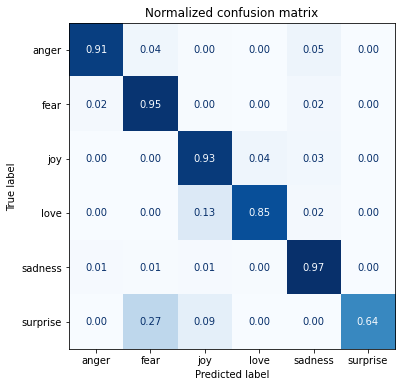

In [ ]:
plot_confusion_matrix(y_preds, y_test, labels)

#### Error analysis

To analyze the difficult cases for the model we will sort the test samples by the model loss.

The following function returns for each sample its model loss and the predicted label. 

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

With `.map()` this function is applied to all samples batchwise. 

In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_tokenized.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_tokenized["test"] = emotions_tokenized["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/100 [00:00<?, ?ba/s]

For easier investigation we create a pandas dataframe:

In [ ]:
emotions_tokenized.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_tokenized["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Data samples with the highest loss (shows the cases the model is strugling with):

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
490,i honestly loved this place and felt pretty co...,sadness,joy,5.123519
1369,i feel like there s a possibility that stateme...,joy,sadness,5.012931
903,i love female vocalists though admit to feelin...,love,sadness,4.986490
745,i can only imagine the countless law suits and...,joy,sadness,4.953499
803,i actually feel solidarity with the americans ...,fear,joy,4.814650
410,i feel super bad because i miss the blogging w...,joy,sadness,4.650672
1029,i feel super bad about it,joy,sadness,4.331078
1587,i think i confuse my feelings of longing with ...,love,joy,4.294610
194,i know it is really hard on him to not be here...,joy,sadness,4.127908
414,i feel like amazing x men compensated enough t...,surprise,joy,4.053486


Data samples with the lowest loss (shows the cases the model is most confident with)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
42,i will probably never feel bouncy so feel free...,joy,joy,0.025091
1290,i did laps and now feel all virtuous,joy,joy,0.025191
395,i feel really lucky to be part of what looks l...,joy,joy,0.025658
1081,im not feeling joyful or spiritually fit,joy,joy,0.026189
222,i feel more energetic than i have in years,joy,joy,0.026294
372,i feel like having read ulysses is a club of r...,joy,joy,0.026348
37,im not feeling too joyful about writing this b...,joy,joy,0.026554
823,i woke up this morning to a text from mr c dec...,joy,joy,0.026619
238,i feel good about the choices i made in terms ...,joy,joy,0.026660
1502,i was very good in the morning as i had been t...,joy,joy,0.026718


Data samples that have been labeled wrongly with the lowest loss:

In [ ]:
df_test[df_test["label"] != df_test["predicted_label"]].sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
537,i feel deer supporting mice parade at the hope...,joy,love,0.744573
1309,i feel in me sparkle sweet passion aretha love...,joy,love,0.750771
1206,i was feeling so overwhelmed that i asked my b...,surprise,fear,0.784309
157,i even feel weird living with lay people again,surprise,fear,0.805673
639,i know you cant just ged rid of your feelings ...,joy,love,0.813309
770,i mean geez cara was raised not to feel compas...,anger,fear,0.816460
1470,im feeling a bit overwhelmed tonight and not r...,surprise,fear,0.829101
439,i admit i was feeling agitated so when hubby a...,anger,fear,0.832878
1499,im feeling a bit dazed and out of sorts like s...,surprise,fear,0.852898
1172,i talk about in this essay is that people feel...,anger,sadness,0.865654


#### Sharing the model

In [ ]:
# HuggingFace account necessary
trainer.push_to_hub(commit_message="Training completed!") 

Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Nov01_16-24-32_e40e0d49dbbe/1667319902.5769038/events.out.tfevents.1667319902.e40e0d49dbbe.74…

Upload file runs/Nov01_16-13-45_e40e0d49dbbe/1667319230.8757112/events.out.tfevents.1667319230.e40e0d49dbbe.74…

Upload file runs/Nov01_16-22-18_e40e0d49dbbe/1667319745.0383217/events.out.tfevents.1667319745.e40e0d49dbbe.74…

Upload file runs/Nov01_16-24-32_e40e0d49dbbe/events.out.tfevents.1667319902.e40e0d49dbbe.74.4:  64%|######3   …

Upload file training_args.bin:  99%|#########9| 3.34k/3.36k [00:00<?, ?B/s]

Upload file runs/Nov01_16-13-45_e40e0d49dbbe/events.out.tfevents.1667319230.e40e0d49dbbe.74.0:  64%|######4   …

Upload file runs/Nov01_16-22-18_e40e0d49dbbe/events.out.tfevents.1667319745.e40e0d49dbbe.74.2:  86%|########6 …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Wiebke/distilbert-base-uncased-finetuned-emotion
   95aad6a..cda9c4b  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Wiebke/distilbert-base-uncased-finetuned-emotion
   95aad6a..cda9c4b  main -> main

To https://huggingface.co/Wiebke/distilbert-base-uncased-finetuned-emotion
   cda9c4b..8af5ff6  main -> main

   cda9c4b..8af5ff6  main -> main



'https://huggingface.co/Wiebke/distilbert-base-uncased-finetuned-emotion/commit/cda9c4b476c3fb50178ad67da657dd9c6578958c'

After sharing our model on the HuggingFace hub we can reuse it for example via the pipeline.

In [ ]:
from transformers import pipeline

# Change `Wiebke` to your Hub username
model_id = "Wiebke/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/883 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:92: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


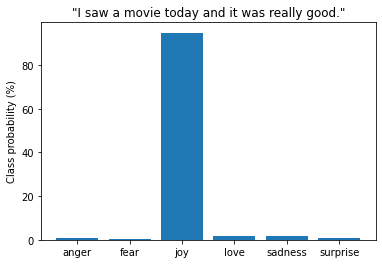

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()